In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
# Move the kaggle.json file into ~/.kaggle, which is where the Kaggle API client expects your token to be located
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d marquis03/cats-and-dogs
!unzip cats-and-dogs.zip -d /content/cats-and-dogs


# **Set Up Data Generators**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/cats-and-dogs/train'  # Adjust this if the path is different

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)  # using 20% of the data for validation

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')


Found 220 images belonging to 2 classes.
Found 55 images belonging to 2 classes.


# **Prepare ResNet50 Model for Transfer Learning**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_model():
    # Load pre-trained ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the convolutional base

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()


94765736/94765736 [==============================] - 0s 0us/step


# **Train the Model**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)


Epoch 1/10
6/6 [==============================] - 84s 14s/step - loss: 0.9273 - accuracy: 0.5957 - val_loss: 0.6271 - val_accuracy: 0.6562
Epoch 2/10
6/6 [==============================] - 52s 9s/step - loss: 0.6409 - accuracy: 0.6543 - val_loss: 0.5879 - val_accuracy: 0.6250
Epoch 3/10
6/6 [==============================] - 55s 9s/step - loss: 0.6599 - accuracy: 0.6223 - val_loss: 0.6000 - val_accuracy: 0.6562
Epoch 4/10
6/6 [==============================] - 47s 8s/step - loss: 0.6817 - accuracy: 0.6064 - val_loss: 0.6068 - val_accuracy: 0.6250
Epoch 5/10
6/6 [==============================] - 53s 9s/step - loss: 0.6011 - accuracy: 0.6809 - val_loss: 0.6248 - val_accuracy: 0.6875
Epoch 6/10
6/6 [==============================] - 51s 9s/step - loss: 0.6115 - accuracy: 0.6489 - val_loss: 0.7207 - val_accuracy: 0.5625
Epoch 7/10
6/6 [==============================] - 47s 8s/step - loss: 0.6024 - accuracy: 0.6968 - val_loss: 0.5383 - val_accuracy: 0.7812
Epoch 8/10
6/6 [=================

# **Visualize Training Results**

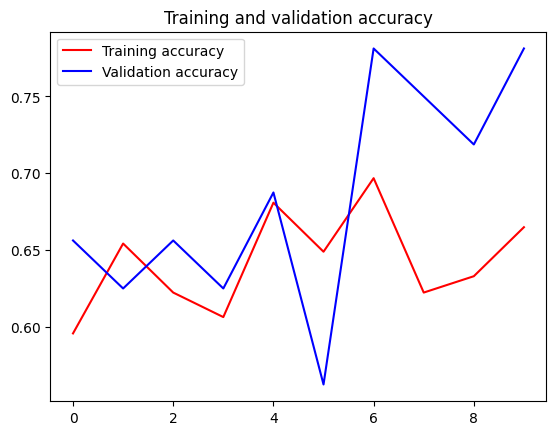

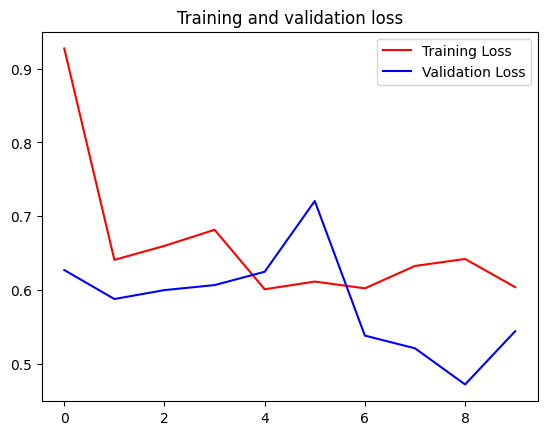

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)
